# Data Forecasting

The module is in charge of: 
- forecasting the value of temperature in the next X seconds; 
- forecasting the value of humidity in the next X seconds; 
- forecasting the value of the gas sensor in the next X seconds 

(X is defined by users or developers). 

The time-series of the predicted values must be saved on INFLUX and shown on the GRAFANA dashboard as well; e.g. by using two lines for the temperature graph, one related to raw measurements, one to predictions. One or multiple techniques for time-series forecasting can be developed and compared.


## Import Dependencies

In [ ]:
!pip3 install influxdb_client
!pip3 install statsmodels
!pip3 install sklearn
!pip3 install cufflinks
!pip3 install pmdarima
!pip3 install chart-studio

In [3]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
#import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import numpy as np
import pandas as pd
import seaborn as sns
import random
from datetime import datetime,timezone
import dateutil.parser
import time
import statsmodels.graphics.tsaplots as tsaplots
from datetime import timedelta
from influxdb_client import InfluxDBClient, Point, WriteOptions
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client.client.write_api import WriteType

## Influx Setting

In [4]:
INFLUXDB_HOST = os.getenv("INFLUX_HOST")
INFLUXDB_PORT = os.getenv("INFLUX_HOST_PORT")
INFLUXDB_ORG = os.getenv("INFLUX_ORG")
INFLUXDB_TOKEN = os.getenv("INFLUX_TOKEN")
client = InfluxDBClient(url="http://"+INFLUXDB_HOST+":"+INFLUXDB_PORT, token=INFLUXDB_TOKEN, org=INFLUXDB_ORG)

### Influx Queries

[<FluxTable: 12 columns, 605 records>]
[<FluxTable: 12 columns, 605 records>]
[<FluxTable: 12 columns, 453 records>]


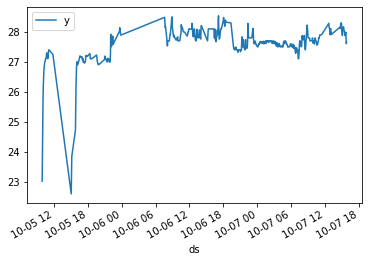

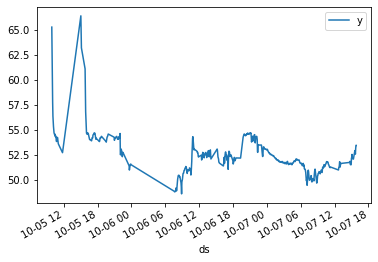

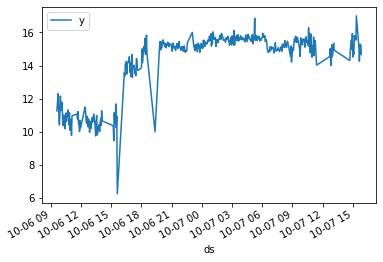

In [10]:
from pandas import DataFrame


def result_to_dataframe(result):
    raw = []
    for table in result:
        for record in table.records:
            raw.append((record.get_time(), record.get_value()))
    return pd.DataFrame(raw, columns=['ds','y'], index=None)
    
buckets = ['temperature', 'humidity', 'gas']
dfTemp = DataFrame
dfHum = DataFrame
dfGas = DataFrame

for bucket in buckets:
    query = 'from(bucket: "' + bucket + '")' \
                ' |> range(start: 2022-10-05T00:00:00.00Z, stop: 2022-10-07T15:50:00.00Z)' \
                ' |> filter(fn: (r) => r["_measurement"] == "val")' \
                ' |> filter(fn: (r) => r["_field"] == "'+bucket+ '")' \
                ' |> aggregateWindow(every: 3m , fn: mean, createEmpty: false)'\
                ' |> yield(name: "mean")'\

    result = client.query_api().query(org=INFLUXDB_ORG, query=query)
    print(result)
    # Convert the results to dataframe
    if (bucket == "temperature" and  result):
        dfTemp = result_to_dataframe(result)
        dfTemp['ds'] = dfTemp['ds'].dt.tz_localize(None)
        #plot data
        plot_cols = ['y']
        plot_features = dfTemp[plot_cols]
        plot_features.index = dfTemp['ds']
        _ = plot_features.plot(subplots=True)

    if (bucket == "humidity" and result):
        dfHum = result_to_dataframe(result)
        dfHum['ds'] = dfHum['ds'].dt.tz_localize(None)
        #plot data
        plot_cols = ['y']
        plot_features = dfHum[plot_cols]
        plot_features.index = dfHum['ds']
        _ = plot_features.plot(subplots=True)

    if (bucket == "gas" and result):
        dfGas = result_to_dataframe(result)
        dfGas['ds'] = dfGas['ds'].dt.tz_localize(None)
        #plot data
        plot_cols = ['y']
        plot_features = dfGas[plot_cols]
        plot_features.index = dfGas['ds']
        _ = plot_features.plot(subplots=True)

### Informations about DataFrames. Train and Test Datasets cretion 

In [23]:
trainTemp = DataFrame
testTemp = DataFrame
trainHum= DataFrame
testHum = DataFrame
trainGas = DataFrame
testGas = DataFrame
testGas2 = DataFrame

if ( not dfTemp.empty):
    print("Temperature Dataset")    
    print(dfTemp.describe().transpose())
    nrows = (len(dfTemp.values))
    splitPoint = int (nrows * 0.60)
    trainTemp = dfTemp['y'] [:splitPoint]
    testTemp = dfTemp ['y'] [splitPoint:]

if (not dfHum.empty):
    print("Humidity Dataset")
    print(dfHum.describe().transpose())
    nrows = (len(dfHum.values))
    splitPoint = int (nrows * 0.60)
    trainHum = dfHum['y'] [:splitPoint]
    testHum = dfHum ['y'] [splitPoint:]

if (not dfGas.empty):
    print("Gas Dataset")
    print(dfGas.describe().transpose())
    nrows = (len(dfGas.values))
    splitPoint = int (nrows * 0.60)
    trainGas = dfGas['y'] [:splitPoint]
    testGas = dfGas ['y'] [splitPoint:]
    testGas2 = dfGas ['ds'] [splitPoint:]
    print(testGas2.head())

Temperature Dataset
   count       mean       std        min        25%        50%        75%  \
y  605.0  27.604689  0.555961  22.590909  27.492308  27.665625  27.871186   

         max  
y  28.535938  
Humidity Dataset
   count      mean      std        min       25%        50%        75%   max
y  605.0  52.46608  1.88294  48.626415  51.49375  52.104615  53.540625  66.4
Gas Dataset
   count       mean       std   min    25%        50%        75%   max
y  453.0  14.350201  1.863604  6.25  14.26  15.150943  15.525424  17.0
271   2022-10-07 03:39:00
272   2022-10-07 03:42:00
273   2022-10-07 03:45:00
274   2022-10-07 03:48:00
275   2022-10-07 03:51:00
Name: ds, dtype: datetime64[ns]


### Check if the time-series are stationary using the Dickey-Fuller test

In [13]:
from statsmodels.tsa.stattools import adfuller

resultTemp = 0.0
resultHum = 0.0
resultGas = 0.0

if (not dfTemp.empty):
    resultTemp = adfuller(trainTemp)
    print('TEMPERATURE: ADF Statistic: %f' % resultTemp[0])
    print('TEMPERATURE: p-value: %f' % resultTemp[1])

if (not dfHum.empty):
    resultHum = adfuller(trainHum)
    print('HUMIDITY: ADF Statistic: %f' % resultHum[0])
    print('HUMIDITY: p-value: %f' % resultHum[1])

if (not dfGas.empty):
    resultGas = adfuller(trainGas)
    print('GAS: ADF Statistic: %f' % resultGas[0])
    print('GAS: p-value: %f' % resultGas[1])
    

TEMPERATURE: ADF Statistic: -4.427097
TEMPERATURE: p-value: 0.000266
HUMIDITY: ADF Statistic: -3.964243
HUMIDITY: p-value: 0.001610
GAS: ADF Statistic: -1.040556
GAS: p-value: 0.738187


### If P Value > 0.05 we go ahead with finding the order of differencing.

GAS: ADF Statistic: -9.992383
GAS: new p-value: 0.000000


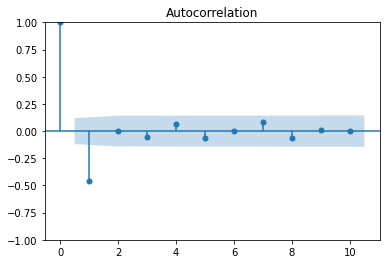

C:\Users\andre\AppData\Roaming\Python\Python39\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



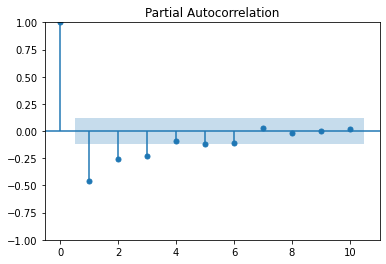

In [14]:
from statsmodels.graphics import tsaplots

if (not dfTemp.empty and resultTemp[1] > 0.05):
    train_new = trainTemp.diff().dropna()
    result = adfuller(train_new)
    print('TEMPERATURE: ADF Statistic: %f' % result[0])
    print('TEMPERATURE: new p-value: %f' % result[1])
    fig = tsaplots.plot_acf(train_new, lags=10)
    plt.show()
    fig = tsaplots.plot_pacf(train_new, lags=10)
    plt.show()

if (not dfHum.empty and resultHum[1] > 0.05):
    train_new = trainHum.diff().dropna()
    result = adfuller(train_new)
    print('HUMIDITY: ADF Statistic: %f' % result[0])
    print('HUMIDITY: new p-value: %f' % result[1])
    fig = tsaplots.plot_acf(train_new, lags=10)
    plt.show()
    fig = tsaplots.plot_pacf(train_new, lags=10)
    plt.show()

if (not dfGas.empty and resultGas[1] > 0.05):
    train_new = trainGas.diff().dropna()
    result = adfuller(train_new)
    print('GAS: ADF Statistic: %f' % result[0])
    print('GAS: new p-value: %f' % result[1])
    fig = tsaplots.plot_acf(train_new, lags=10)
    plt.show()
    fig = tsaplots.plot_pacf(train_new, lags=10)
    plt.show()

### Apply ARIMA model to all Datasets

In [18]:
from statsmodels.tsa.arima.model import ARIMA
import math
from sklearn.metrics import mean_squared_error

if (not trainTemp.empty):
  historyTemp = [x for x in trainTemp]
  predictionsTemp = list()
if (not trainHum.empty):
  historyHum = [x for x in trainHum]
  predictionsHum = list()
if (not trainGas.empty):
  historyGas= [x for x in trainGas]
  predictionsGas = list()

if (not dfTemp.empty):
  for t in testTemp.index:
    model = ARIMA(historyTemp, order=(0,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yest = output[0]
    predictionsTemp.append(yest)
    obs= testTemp[t]
    print(obs)
    historyTemp.append(obs)
    print ('predicted=%f, expected=%f' % (yest, obs))

if (not dfHum.empty):
  for t in testHum.index:
    model = ARIMA(historyHum, order=(0,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yest = output[0]
    predictionsHum.append(yest)
    obs= testHum[t]
    historyHum.append(obs)
    print ('predicted=%f, expected=%f' % (yest, obs))

if (not dfGas.empty):
  for t in testGas.index:
    model = ARIMA(historyGas, order=(0,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yest = output[0]
    predictionsGas.append(yest)
    obs= testGas[t]
    historyGas.append(obs)
    print ('predicted=%f, expected=%f' % (yest, obs))
    


27.673437500000006
predicted=27.553690, expected=27.673438
27.62641509433962
predicted=27.554019, expected=27.626415
27.6375
predicted=27.554217, expected=27.637500
27.66538461538461
predicted=27.554445, expected=27.665385
27.673437500000013
predicted=27.554747, expected=27.673438
27.629687499999985
predicted=27.555070, expected=27.629687
27.649230769230744
predicted=27.555272, expected=27.649231
27.62812499999999
predicted=27.555526, expected=27.628125
27.646875000000012
predicted=27.555721, expected=27.646875
27.685937500000012
predicted=27.555966, expected=27.685938
27.612280701754372
predicted=27.556315, expected=27.612281
27.603124999999977
predicted=27.556464, expected=27.603125
27.603124999999974
predicted=27.556589, expected=27.603125
27.61846153846153
predicted=27.556713, expected=27.618462
27.651562500000008
predicted=27.556876, expected=27.651563
27.65660377358492
predicted=27.557127, expected=27.656604
27.695384615384647
predicted=27.557389, expected=27.695385
27.6468749999

C:\Users\andre\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



27.5
predicted=27.566300, expected=27.500000
27.52031249999998
predicted=27.566150, expected=27.520312


C:\Users\andre\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



27.64218750000002
predicted=27.566046, expected=27.642188
27.685937500000016
predicted=27.566218, expected=27.685938
27.659374999999986
predicted=27.566487, expected=27.659375
27.604081632653056
predicted=27.566695, expected=27.604082
27.68000000000003
predicted=27.566779, expected=27.680000
27.700000000000028
predicted=27.567031, expected=27.700000
27.696226415094365
predicted=27.567328, expected=27.696226
27.690625000000022
predicted=27.567614, expected=27.690625
27.69531250000002
predicted=27.567887, expected=27.695313
27.663076923076915
predicted=27.568169, expected=27.663077
27.598333333333308
predicted=27.568378, expected=27.598333
27.614754098360642
predicted=27.568444, expected=27.614754
27.592187499999977
predicted=27.568546, expected=27.592187
27.57142857142856
predicted=27.568598, expected=27.571429
27.5609375
predicted=27.568604, expected=27.560938
27.5
predicted=27.568587, expected=27.500000
27.51406249999999
predicted=27.568438, expected=27.514062
27.5015625
predicted=27.

C:\Users\andre\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



27.852307692307726
predicted=27.577587, expected=27.852308
27.90000000000003
predicted=27.578070, expected=27.900000
27.90000000000003
predicted=27.578636, expected=27.900000
27.900000000000027
predicted=27.579200, expected=27.900000
27.90000000000003
predicted=27.579762, expected=27.900000
27.90000000000003
predicted=27.580322, expected=27.900000
27.90000000000003
predicted=27.580879, expected=27.900000
27.900000000000006
predicted=27.581435, expected=27.900000
28.287037037037017
predicted=27.581989, expected=28.287037
28.138461538461502
predicted=27.583213, expected=28.138462
28.128125000000008
predicted=27.584176, expected=28.128125
28.081250000000004
predicted=27.585117, expected=28.081250
27.90312500000003
predicted=27.585974, expected=27.903125
27.934375
predicted=27.586521, expected=27.934375
28.113846153846126
predicted=27.587119, expected=28.113846
28.00625
predicted=27.588024, expected=28.006250
27.996875000000003
predicted=27.588742, expected=27.996875
27.912698412698447
pre

In [44]:
def send_predictions(dataframe, bucket):
	testGas2.columns=['ds']
	lines = [str(dataframe['y'][d]) for d in range(len(dataframe))]
	print(lines)
	lines = ['val,prediction=yes,clientId=' + str("diubi-esp-32")+",lat=999,lng=999"+ " " + bucket + '=' + str(dataframe['y'][d])
									+ ' ' + str(int(time.mktime(testGas2['ds'][d].timetuple())) + 3600*2) + "000000000" for d in range(len(dataframe))]
	write_client = client.write_api(write_options=WriteOptions(batch_size=1000, flush_interval=10_000,
															jitter_interval=2_000, retry_interval=5_000, write_type=WriteType.synchronous))
	write_client.write(bucket, INFLUXDB_ORG, lines)

In [41]:

print(testGas2.head())

271   2022-10-07 03:39:00
272   2022-10-07 03:42:00
273   2022-10-07 03:45:00
274   2022-10-07 03:48:00
275   2022-10-07 03:51:00
Name: ds, dtype: datetime64[ns]


### ARIMA model evaluation (RMSE)

Test RMSE: 0.229


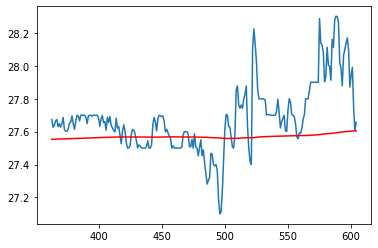

Test RMSE: 1.458


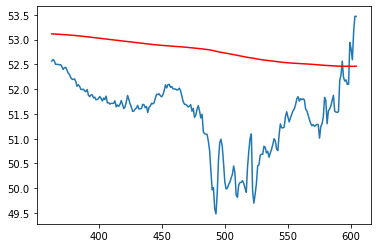

Test RMSE: 0.870
['14.59555725752677', '14.324615418555018', '14.621319909161398', '14.466922919455465', '14.49457383630294', '14.645237121363456', '14.454916751300047', '14.609660246526161', '14.425000722723674', '14.64678475100562', '14.4177087434218', '14.556838700079899', '14.533767235382106', '14.505367873383177', '14.43935126280784', '14.785686553203744', '14.508719778493752', '14.588525366737164', '14.419160968474957', '14.710277856153295', '14.663711121500386', '14.550685293169874', '14.701574208443109', '14.504749892954843', '14.596431387291718', '14.56192922141847', '14.49984783154198', '14.601405912878368', '14.768626400817174', '14.461163883114212', '14.491892437993931', '14.7274506728966', '14.734083927430676', '15.410417310324181', '14.011555006389148', '14.995643420733819', '14.509945755917531', '14.823818564815827', '14.433915900232714', '14.85774295637371', '14.493864730836696', '14.866289253509057', '14.542204076710364', '14.64311646678297', '14.681324620748335', '14.

KeyError: 'ds'

In [45]:
if (not trainTemp.empty):
  rmse = math.sqrt(mean_squared_error(testTemp, predictionsTemp))
  print('Test RMSE: %.3f'% rmse)
  df2 = pd. DataFrame (predictionsTemp)
  df2.set_index(testTemp.index, inplace=True)
  plt.plot(testTemp)
  plt.plot(df2, color='red')
  plt.show()
  

if (not trainHum.empty):
  rmse = math.sqrt(mean_squared_error(testHum, predictionsHum))
  print('Test RMSE: %.3f'% rmse)

  df2 = pd. DataFrame (predictionsHum)
  df2.set_index(testHum.index, inplace=True)
  plt.plot(testHum)
  plt.plot(df2, color='red')
  plt.show()

if (not trainGas.empty):
  rmse = math.sqrt(mean_squared_error(testGas, predictionsGas))
  print('Test RMSE: %.3f'% rmse)

  df2 = pd. DataFrame (predictionsGas)
  df2.columns = ['y']
  send_predictions(df2,"gas")
  df2.set_index(testGas.index, inplace=True)
  plt.plot(testGas)
  plt.plot(df2, color='red')
  plt.show()
